# Import packages and call variables

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import reionizer
import matplotlib.lines as mlines
import run_LF as LF



## this is manipulated data from original code in README

#/Users/alexamia/Desktop/REU2020_DATA/REU2020/data/models/M18_z\=7.0_lnpWobs_Muv
# Colors
from palettable.colorbrewer.sequential import Purples_6
from palettable.colorbrewer.sequential import Oranges_6
from palettable.colorbrewer.sequential import Greens_6
from palettable.colorbrewer.sequential import Blues_6
from palettable.colorbrewer.sequential import Reds_6

seqcols = [Blues_6.hex_colors, Greens_6.hex_colors, Purples_6.hex_colors, Oranges_6.hex_colors]

pW_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
pW_dir = pW_data_dir+'M18_z=7.0_lnpWobs_Muv/' #inside models folder call M18_z=7.0_lnpWobs_Muv folder
pW_files = sorted(reionizer.insensitive_glob(pW_dir+'ln_pWobs_*.txt')) #calls each file in modelled data * will be replaced with corresponding xHI

#Call xHI files
xHI_tab = np.array([float(f.split('xHI=')[-1].split('.txt')[0]) for f in pW_files]) 
#For each float in pW_files, call each xHI, -1 returns last item and 0 returns first item, so it gets xHI=___.txt


def load_pW_pandas(lypW_filename): ##defined parameter as my_function then eventually paseed lnpW_file into it
    """
    Load table into pandas df
    """
    lnpW_tab_df = pd.read_csv(lypW_filename, skiprows=1, delim_whitespace=True)
    
    # Shuffle the column names to remove the '#' from the first column
    lnpW_tab_df.columns = np.roll(lnpW_tab_df.columns, -1)

    # Cut off the last (empty) column
    lnpW_tab_df = lnpW_tab_df.iloc[:, :-1]

    return lnpW_tab_df

#Now call arrays for corresponding xHI values and Muvs being looked at
xHI_array = np.array([0.01,0.05, 0.36, 0.66, 0.87])
Muv_array = np.array([-18.0,-22.0])


/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:38: RuntimeWarning: divide by zero encountered in log10
  log10_lg = np.log10(lum_grid) #log10 luminosity grid in order to plot it on log10 scale similar to past works


# Plotting data

In [31]:
# Max G EW data

def DW_Wc(Muv, z=6.):
    # Scale length
    Wc0    = 23.
    dWdMuv = 7.
    dWdz   = 6.
    if Muv < -19.:
        return Wc0 + dWdMuv * (Muv + 21.9) + dWdz * (z - 4.)
    if Muv >= -19.:
        return Wc0 + dWdMuv * (-19. + 21.9) + dWdz * (z - 4.)
def DW_Wmin(Muv):
    # Min W for normalisation
    if Muv < -21.5:
        wmin = 20.
    elif -21.5 <= Muv <= -19.:
        wmin = 20. - 6. * (Muv + 21.5) ** 2.
    else:
        wmin = -17.5
    return -wmin
def DW_delta(Muv):
    # Factor for delta function at W=0 for truncated DW12 PDF
    A = 1. - np.exp(DW_Wmin(Muv)/DW_Wc(Muv))
    return A
def p0W_DijkstraWyithe(Muv, W, z=6., norm=True):
    """
    Intrinsic rest-frame equivalent width distribution
    Dijkstra & Wyithe 2012
        Defined for -21.5 < Muv < -19
    Lots of typos, so use Gronke+2015 to get params
    """
    dW   = np.median(np.gradient(W))
    Wmax = 1000.
    # Normalization
    a = - DW_Wmin(Muv)
    N = np.exp(-a / DW_Wc(Muv, z)) / DW_Wc(Muv, z)
    pW   = N * np.exp(-W / DW_Wc(Muv, z))
    pW[W < -a]   = 0.
    pW[W > Wmax] = 0.
    if norm:
        pW = pW / np.trapz(pW, W)
    return pW

MaxG = [p0W_DijkstraWyithe(Muv= Muv, W = pW_tab['W'], z=6., norm=True) for Muv in LF.Muv_grid]


AttributeError: 'list' object has no attribute 'ndim'

ValueError: x and y must have same first dimension, but have shapes (120, 10000) and (10000,)

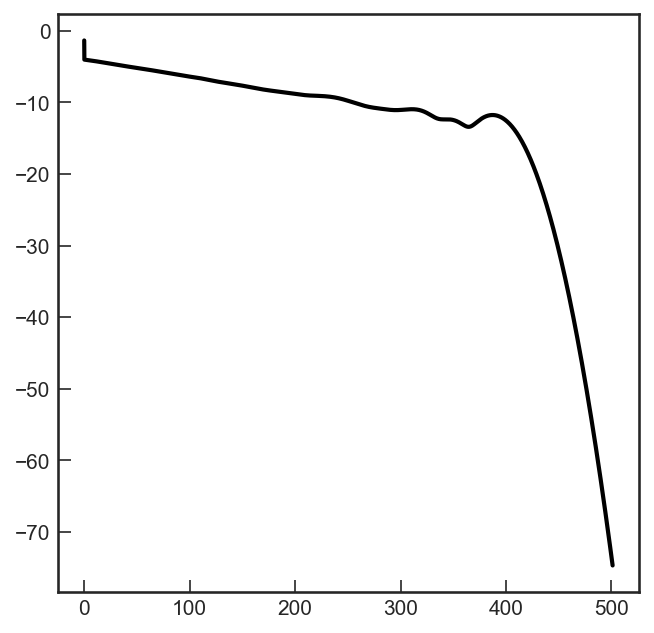

In [29]:
# Plot
plt.figure(figsize=(5,5), dpi=150.)

#For loop, regarding xHI and Muv
for xx,xHI in enumerate (xHI_tab): #for each index and corresponding xHI value in list of xHI, call specific data file
    if xHI in xHI_array:
        pW_tab = load_pW_pandas(pW_files[xx]) #when all files are called, if the value run is within the array, then call that data file
        
        #Colors being used for plotting data, this statement is used bc otherwise, xHI=0.01 and 0.05 would be plotted with the same color
        if xHI==0.01:
                my_color = 'black'
        else:
                my_color = seqcols[int(xx/10)][-3]
                
        #Within if statement, this is for identifying xHI legend (values and corresponding colors)
        for mm,Muv in enumerate (Muv_array):
            if mm == 0: #first item in Muv_array, i.e. -18.0 (will show xHI values and corresponding colors as solid)
                label = r'$\overline{x}_\mathrm{HI} = %.2f$' % xHI
                ls = 'solid'
            else: #second item in Muv_array, i.e. -22.0 (will not show on xHI legend)
                label = None
                ls = 'dashed'
#             MaxG = p0W_DijkstraWyithe(Muv= pW_tab[f'{Muv}'], W = pW_tab['W'], z=6., norm=True)
            plt.plot(pW_tab['W'], pW_tab[f'{Muv}'], ls=ls, color=my_color, lw=2, label=label)
            plt.plot(MaxG,pW_tab[f'{Muv}'])          
#Legends      
leg_xHI = plt.legend(frameon=False, handletextpad=0.5)
plt.gca().add_artist(leg_xHI)

#This is the legend for Muv values, -18.0 is solid, -22.0 is dashed
line1 = mlines.Line2D([], [], color='k', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[0])
line2 = mlines.Line2D([], [], color='k', ls='dashed', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[1])
plt.legend(handles=[line1, line2], loc='lower left', frameon=False, handletextpad=0.5, handlelength=1.5)

plt.xlim(-10.,150.)
plt.ylim(-20.,0.)

plt.xlabel('$W$ [$\mathrm{\AA}$]')
plt.ylabel(r'$\ln{ p(W \;|\; \overline{x}_\mathrm{HI}, M_\mathrm{UV})}$')
plt.title(r'Ly-$\alpha$ EW Probability Distribution')
plt.tight_layout()

# save the figure
# plt.savefig('LyaEWPD2.pdf', dpi=300, bbox_inches='tight')

# plt.show()


SyntaxError: keyword can't be an expression (<ipython-input-6-f98f13c39af3>, line 1)